In [1]:
#Make sure you have the input file in the same folder as the notebook.
#This will plot mulitple results on the graph if you have the format specified.

In [2]:
!pip install pandas --upgrade
!pip install scikit-learn --upgrade
!pip install matplotlib --upgrade

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.me

In [3]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data_multi = pd.read_csv('docked_combined_multi_python.csv')

In [6]:
data_multi.head(10)

,S,ID,Rank1,real,Rank2
0,-8.274622,BI-7190,0,active,0.0
1,-6.818402,(S)-AU1,173,active,NaN
2,-6.593113,TP-238,689,active,NaN
3,-6.414602,BZ1,1698,active,73.0
4,-6.332542,BZ2,2443,active,97.0
5,-6.274476,BI-4827_NC,3080,active,42.0
6,-6.263610,DC-BPi-11,3231,active,638.0
7,-6.239370,NVS-BPTF-1,3512,active,NaN
8,-6.017718,BZ1_NC,6854,active,NaN
9,-5.532773,GSK4027,13120,active,216.0


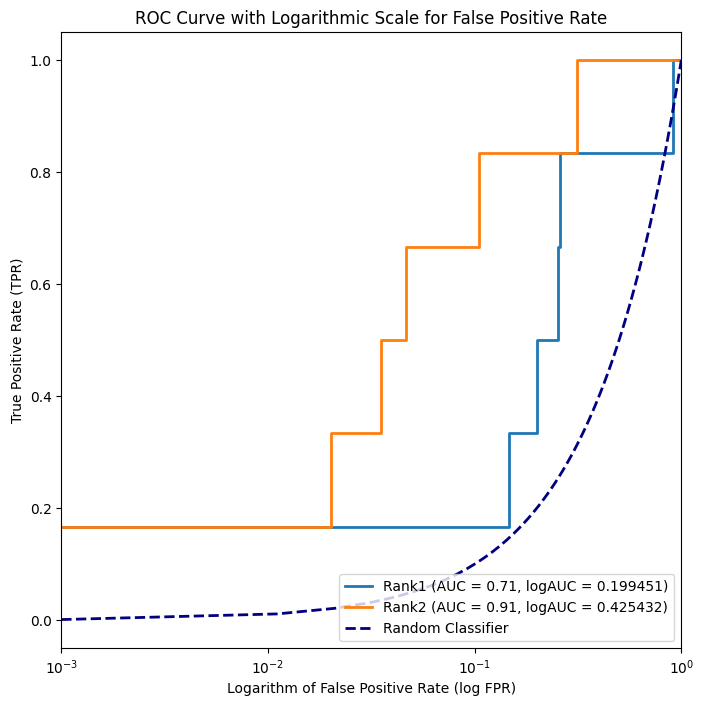

In [7]:
# Example DataFrame (replace this with your actual data)
# data_multi = pd.DataFrame({'Rank1': [...], 'Rank2': [...], 'Rank3': [...], 'real': [...]})

# Ensure the DataFrame contains the necessary columns and no NaNs
if 'real' not in data_multi.columns:
    raise ValueError("DataFrame must contain a 'real' column")

# Drop rows with NaNs in any rank columns or 'real'
rank_columns = ['Rank1', 'Rank2']  # Add all your rank columns here
data_multi = data_multi.dropna(subset=rank_columns + ['real'])

positive_class = 'active'

# Convert 'real' column to binary labels
data_multi['binary_real'] = (data_multi['real'] == positive_class).astype(int)

log_auc_threshold = 0.001

plt.figure(figsize=(8, 8))

# Iterate over each rank column
for rank_col in rank_columns:
    # Sorting the DataFrame based on the current rank column in ascending order
    sorted_data = data_multi.sort_values(by=rank_col, ascending=True)

    # Calculate true positive rate (sensitivity), false positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(sorted_data['binary_real'], -sorted_data[rank_col])  # Negate 'Rank' to treat lower ranks as better
    roc_auc = auc(fpr, tpr)

    # Calculate logAUC using the provided formula
    log_auc = 0.0
    for i in range(len(fpr) - 1):
        if fpr[i] >= log_auc_threshold:
            log_auc += (np.log10(fpr[i + 1]) - np.log10(fpr[i])) * ((tpr[i + 1] + tpr[i]) / 2)
    log_auc /= np.log10(1.0 / log_auc_threshold)

    # Take the logarithm of FPR
    log_fpr = np.log10(fpr + 1e-10)  # Adding a small constant to avoid zero values

    # Plot ROC curve
    plt.plot(log_fpr, tpr, lw=2, label=f'{rank_col} (AUC = {roc_auc:.2f}, logAUC = {log_auc:.6f})')

# Plot the random classifier line
random_fpr = np.linspace(log_auc_threshold, 1, 100)
random_tpr = random_fpr
log_random_fpr = np.log10(random_fpr)
plt.plot(log_random_fpr, random_tpr, color='navy', lw=2, linestyle='--', label='Random Classifier')

# Set x-axis limits from the log threshold to 0
plt.xlim(np.log10(log_auc_threshold), 0)

# Set x-axis ticks in the format of 10^x
xticks = np.arange(np.floor(np.log10(log_auc_threshold)), 1, 1)
xticklabels = [f'$10^{{{int(x)}}}$' for x in xticks]
plt.xticks(xticks, xticklabels)

plt.xlabel('Logarithm of False Positive Rate (log FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with Logarithmic Scale for False Positive Rate')
plt.legend(loc="lower right")
plt.show()